In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [25]:
df_train = pd.read_csv('data/train.csv')
df_holidays = pd.read_csv('data/holidays_events.csv')
df_oil = pd.read_csv('data/oil.csv')
df_stores = pd.read_csv('data/stores.csv')
df_transactions = pd.read_csv('data/transactions.csv')

In [26]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

In [28]:
df_oil = df_oil.set_index('date').asfreq('D')
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear', limit_direction='forward')
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].ffill()
df_oil = df_oil.reset_index()

In [29]:
df_holidays = df_holidays[df_holidays['transferred'] == False]
df_holidays = df_holidays.rename(columns={'type': 'holiday_type'})

In [30]:
df_merged = df_train.merge(df_stores, on='store_nbr', how='left')
df_merged = df_merged.merge(df_oil, on='date', how='left')
df_merged = df_merged.merge(df_holidays[['date', 'holiday_type', 'locale']], on='date', how='left')

df_merged['holiday_type'] = df_merged['holiday_type'].fillna('No Holiday')
df_merged['locale'] = df_merged['locale'].fillna('No Locale')

In [31]:
df_merged['year'] = df_merged['date'].dt.year
df_merged['month'] = df_merged['date'].dt.month
df_merged['day'] = df_merged['date'].dt.day
df_merged['day_of_week'] = df_merged['date'].dt.dayofweek
df_merged['is_weekend'] = df_merged['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [32]:
le = LabelEncoder()
cols_to_encode = ['family', 'city', 'state', 'type', 'holiday_type', 'locale']

for col in cols_to_encode:
    df_merged[col] = le.fit_transform(df_merged[col].astype(str))

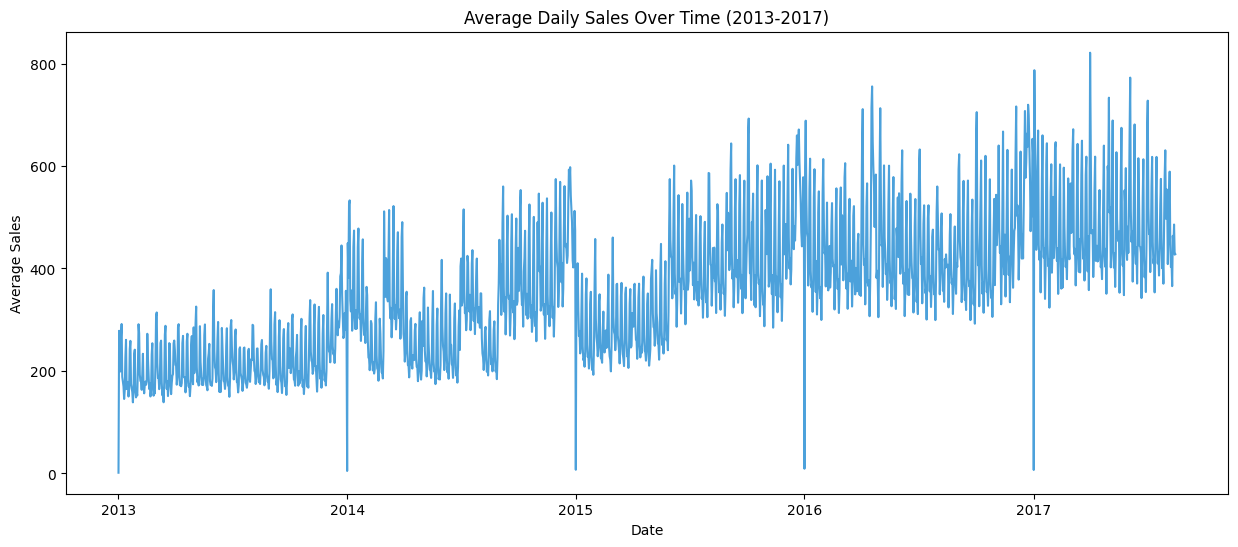

In [33]:
plt.figure(figsize=(15, 6))
daily_sales = df_merged.groupby('date')['sales'].mean()
plt.plot(daily_sales.index, daily_sales.values, alpha=0.7, color='#007acc')
plt.title('Average Daily Sales Over Time (2013-2017)')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.show()

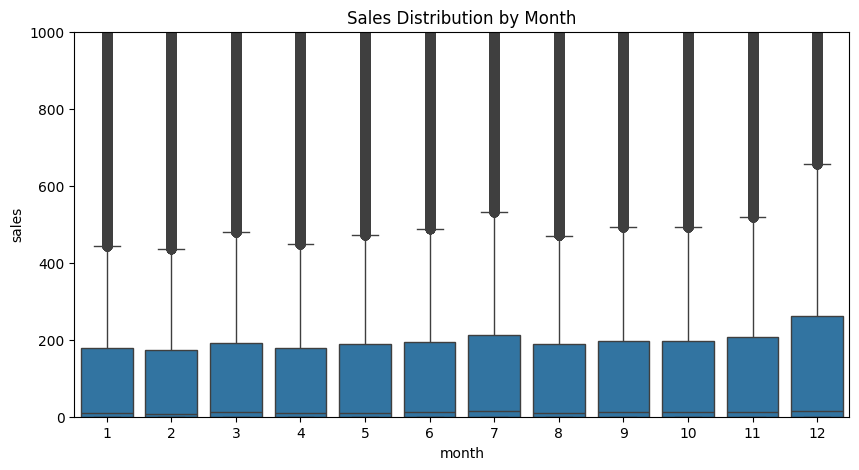

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='sales', data=df_merged)
plt.title('Sales Distribution by Month')
plt.ylim(0, 1000)
plt.show()

In [41]:
df_merged_cleaned = df_merged.dropna(subset=['sales'])

split_date = '2017-07-15'

train_data = df_merged[df_merged['date'] < split_date]
val_data = df_merged[df_merged['date'] >= split_date]

features = ['store_nbr', 'family', 'onpromotion', 'dcoilwtico', 
            'year', 'month', 'day', 'day_of_week', 'is_weekend', 
            'city', 'state', 'type', 'cluster', 'holiday_type']
target = 'sales'

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

print(f"Training shapes {X_train.shape}")
print(f"Validation shapes {X_val.shape}")

Training shapes (2997324, 14)
Validation shapes (57024, 14)


In [37]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

[0]	validation_0-rmse:1068.37319	validation_1-rmse:1243.46623
[49]	validation_0-rmse:526.16637	validation_1-rmse:465.32492


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [38]:
y_pred = xgb_model.predict(X_val)
y_pred = np.maximum(y_pred, 0)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE {rmse:.2f}")
print(f"MAE {mae:.2f}")

RMSE 465.32
MAE 192.52


<Figure size 1000x800 with 0 Axes>

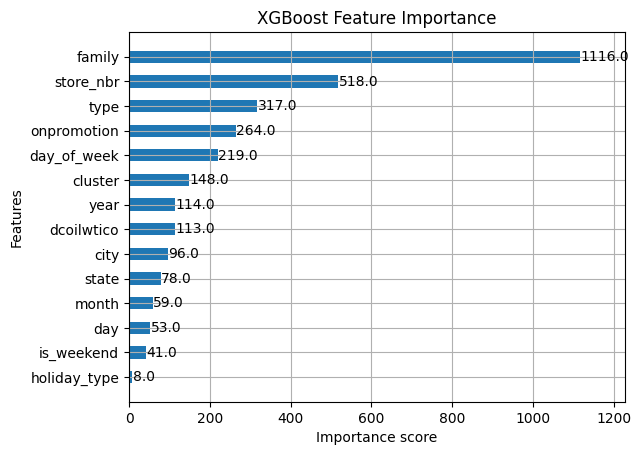

In [39]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=15, height=0.5)
plt.title('XGBoost Feature Importance')
plt.show()

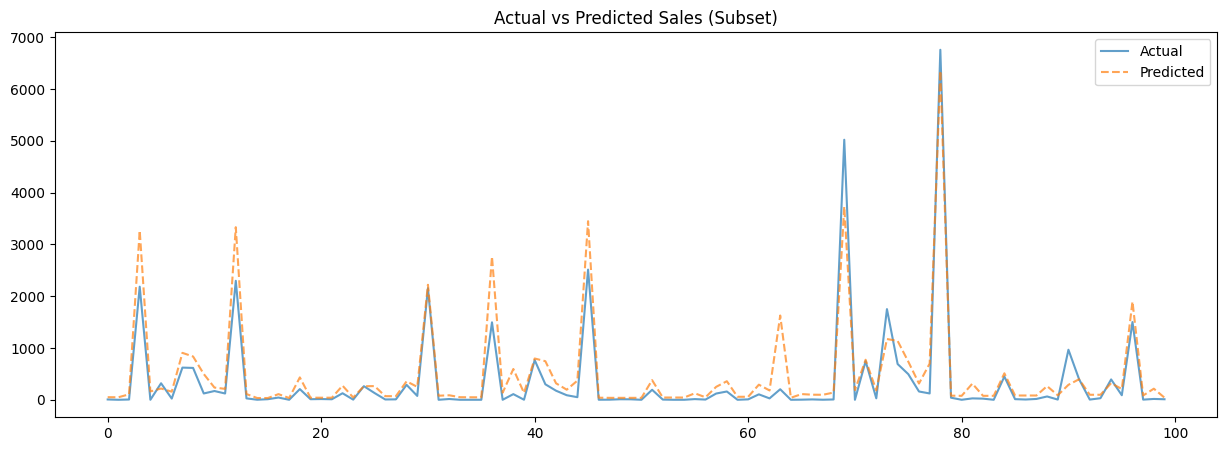

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(y_val.values[:100], label='Actual', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted', alpha=0.7, linestyle='--')
plt.title('Actual vs Predicted Sales (Subset)')
plt.legend()
plt.show()